In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data\AAPM21'
folder = 'CT resolution'

ct = np.load(os.path.join(directory, folder, 'CT_norm.npy'))

c_vals = np.load(os.path.join(directory, folder, 'mtf_contrast_vals.npz'), allow_pickle=True)['arr_0']
c_vals = c_vals.item()

contrast_vals = c_vals['contrast']
plastic_std = c_vals['std_1']
air_std = c_vals['std_2']
std_vals = np.load(os.path.join(directory, folder, 'mtf_pattern_std.npy'))

In [2]:
bar_size = np.array([1, 0.75, 0.66, 0.5, 0.33, 0.25])  # [mm] spot sizes for CT resolution phantom

# calculate the frequency in line pairs per mm or use the known freq
freq = 1 / (2 * bar_size)

# M' is the measured noise (STD) in each of the bar patterns, uncorrected
M_prime = std_vals

# squared noise using ROIs of air and plastic
# N^2 = (Np^2+Nw^2)/2
noise_2 = (air_std ** 2 + plastic_std ** 2) / 2
# correct std of bar patterns for noise using the water ROI, M = sqrt(M'^2-N^2)
M = []
for std in M_prime:
    if std ** 2 > noise_2:
        M.append(np.sqrt(std ** 2 - noise_2))
    else:
        M.append(0)

# M = np.array([np.sqrt(std_16**2-noise_2),np.sqrt(std_13**2-noise_2),np.sqrt(std_10**2-noise_2),
#             np.sqrt(std_08**2-noise_2),np.sqrt(std_06**2-noise_2),np.sqrt(std_05**2-noise_2)])

# M0 = (CT1-CT2)/2: |Air - Plastic|/2
M0 = contrast_vals / 2

# MTF = (pi*sqrt(2)/4)*(M/M0)
MTF = (np.pi * np.sqrt(2) / 4) * (M / M0)

Limiting resolution: 1.23 lp/mm, 0.406 mm


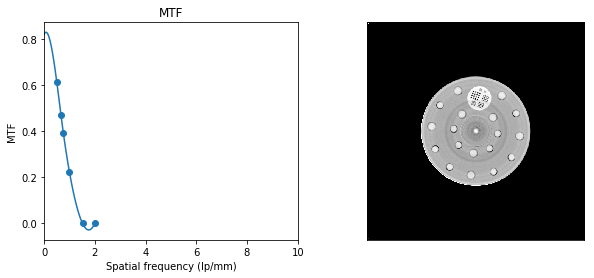

In [32]:
# z = np.polyfit(freq, MTF, 2)
# f = np.poly1d(z)
mtf_fit = CubicSpline(freq, MTF)

freq_fit = np.linspace(0, 2, 100)

# Find the 0.1 spot
mtf_new = mtf_fit(freq_fit)
idx = np.abs(mtf_new - 0.1).argmin()
print(f'Limiting resolution: {freq_fit[idx]:0.2f} lp/mm, {1/(2*freq_fit[idx]):0.3f} mm')


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(freq, MTF)
ax[0].plot(freq_fit, mtf_new)
ax[0].set_title('MTF')
ax[0].set_ylabel('MTF')
ax[0].set_xlabel('Spatial frequency (lp/mm)')
ax[0].set_xlim([0, 10])

ax[1].imshow(ct[11], vmin=-800, vmax=100, cmap='gray')
ax[1].axes.xaxis.set_ticks([])
ax[1].axes.yaxis.set_ticks([])
ax[1].grid(False)
plt.show()

# Save the MTF
np.save(os.path.join(directory, folder, 'mtf.npy'), np.array([freq, MTF]))